In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
import tensorflow.keras.applications.resnet50
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
import os
import numpy as np
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [ ]:
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Found 553 files belonging to 2 classes.
Using 388 files for training.
Found 553 files belonging to 2 classes.
Using 165 files for validation.
Batches for testing --> tf.Tensor(1, shape=(), dtype=int64)
Batches for validating --> tf.Tensor(4, shape=(), dtype=int64)
(100, 224, 224, 3)
(100,)


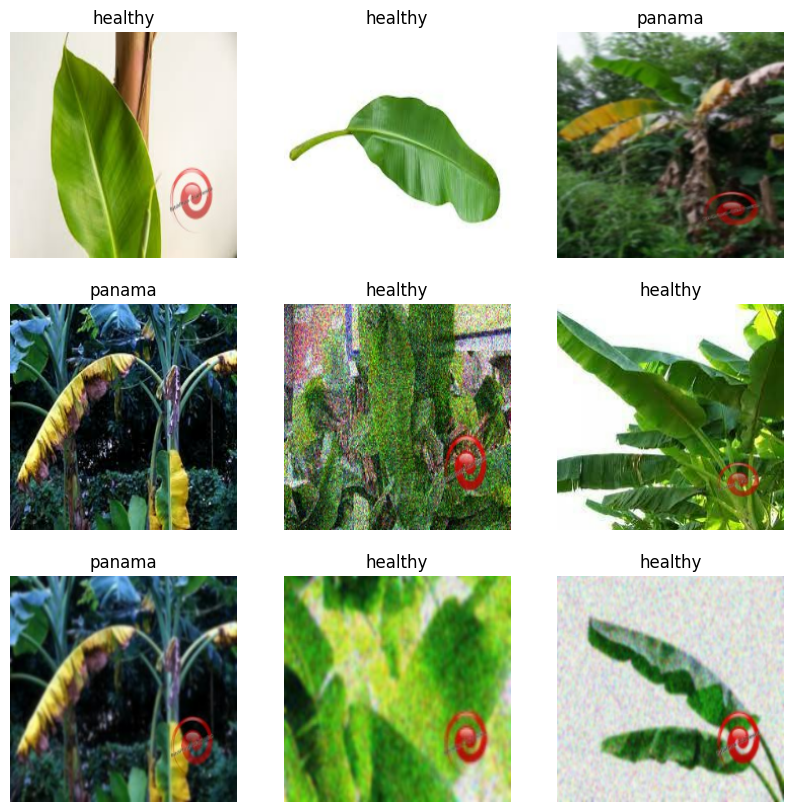

In [ ]:
image_height = 224
image_width = 224

data_train= tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/banana_train',
    labels='inferred',
    label_mode = "int",
    class_names = ['panama', 'healthy'],
    color_mode= 'rgb',
    batch_size= 100,
    image_size= (image_height, image_width),
    shuffle = True,
    seed = 57,
    validation_split = 0.30,
    subset = "training",
)


#data_train, info = tfds.load("horses_or_humans", with_info=True, split='train[:80%]')

data_valid = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/banana_train',
    labels='inferred',
    label_mode = "int",
    class_names = ['panama', 'healthy'],
    color_mode= 'rgb',
    batch_size= 40,
    image_size= (image_height, image_width),
    shuffle = True,
    seed = 57,
    validation_split = 0.30,
    subset = "validation",
)

# Adjust the number of batches for testing and validation based on your requirement.
num_test_batches = 1  # for example

data_test = data_valid.take(num_test_batches)
data_valid = data_valid.skip(num_test_batches)

print('Batches for testing -->', data_test.cardinality())
print('Batches for validating -->', data_valid.cardinality())

class_names = data_train.class_names

for image_batch, labels_batch in data_train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

plt.figure(figsize=(10, 10))
for images, labels in data_train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
import os
import cv2
import numpy as np

def remove_low_res_images(directory, width_threshold, height_threshold):
    """Remove images with resolution below the given threshold."""
    for subdir, _, files in os.walk(directory):
        for file in files:
            filepath = os.path.join(subdir, file)
            image = cv2.imread(filepath)
            height, width = image.shape[:2]

            if width < width_threshold or height < height_threshold:
                os.remove(filepath)
                print(f"Removed {filepath} due to low resolution.")

def remove_blurry_images(directory, focus_threshold=100):
    """Remove images considered blurry based on the variance of Laplacian."""
    for subdir, _, files in os.walk(directory):
        for file in files:
            filepath = os.path.join(subdir, file)
            image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
            if image is None:
                continue

            fm = cv2.Laplacian(image, cv2.CV_64F).var()

            if fm < focus_threshold:
                os.remove(filepath)
                print(f"Removed {filepath} due to being blurry.")

# Example usage:
directory = '/content/drive/MyDrive/Banana'
remove_low_res_images(directory, width_threshold=100, height_threshold=100) # This threshold is an example. Adjust it based on your needs.
remove_blurry_images(directory, focus_threshold=100) # Adjust focus_threshold based on your needs.

In [ ]:
data_train = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Banana_train',
    labels='inferred',
    label_mode="int",
    class_names=['panama', 'healthy'],
    color_mode='rgb',
    batch_size=32,
    image_size=(image_height, image_width),
    shuffle=True,
    seed=57,
    validation_split=0.30,
    subset="training"
)

data_valid = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Banana_train',
    labels='inferred',
    label_mode="int",
    class_names=['panama', 'healthy'],
    color_mode='rgb',
    batch_size=128,
    image_size=(image_height, image_width),
    shuffle=True,
    seed=57,
    validation_split=0.30,
    subset="validation"
)


Found 450 files belonging to 2 classes.
Using 315 files for training.
Found 450 files belonging to 2 classes.
Using 135 files for validation.


In [ ]:
base = keras.applications.ResNet50(input_shape = (image_height, image_width, 3), weights='imagenet', include_top=False)
base.trainable = False

In [ ]:
from keras.layers import Dense, Dropout, Input, GlobalAveragePooling2D
from keras.models import Model
from keras.applications import ResNet50
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

input = Input(shape=(224, 224, 3))
x = data_augmentation(input)  # Data augmentation layer
x = base(x, training=False)   # ResNet50 base model
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)  # Dropout rate
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)  # Adjusted L2 regularization
x = Dropout(0.3)(x)  # Additional dropout layer after the dense layer
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input, outputs=output)

model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_5  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_10 (Dropout)        (None, 2048)              0         
                                                                 
 dense_10 (Dense)            (None, 256)               524544    
                                                           

Model Diagram

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import plot_model

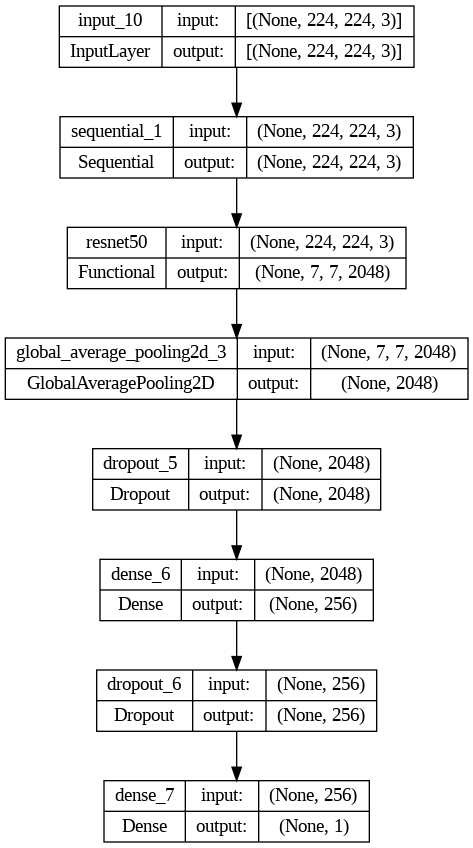

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Train Model

In [ ]:
model.compile(
    optimizer = Adam(learning_rate = 0.09),
    loss = keras.losses.BinaryCrossentropy(),
    metrics = [keras.metrics.BinaryAccuracy()],
)

epochs = 200
history = model.fit(data_train, epochs=epochs, validation_data=data_valid)

Epoch 1/200
4/4 [==============================] - 12s 869ms/step - loss: 100.6834 - binary_accuracy: 0.5902 - val_loss: 21.1990 - val_binary_accuracy: 0.8400
Epoch 2/200
4/4 [==============================] - 3s 555ms/step - loss: 20.4883 - binary_accuracy: 0.9124 - val_loss: 22.4625 - val_binary_accuracy: 0.9600
Epoch 3/200
4/4 [==============================] - 3s 561ms/step - loss: 21.1567 - binary_accuracy: 0.9356 - val_loss: 23.6716 - val_binary_accuracy: 0.9280
Epoch 4/200
4/4 [==============================] - 3s 755ms/step - loss: 22.3770 - binary_accuracy: 0.9175 - val_loss: 22.8428 - val_binary_accuracy: 0.8720
Epoch 5/200
4/4 [==============================] - 4s 760ms/step - loss: 21.8762 - binary_accuracy: 0.9356 - val_loss: 19.8926 - val_binary_accuracy: 0.9760
Epoch 6/200
4/4 [==============================] - 3s 549ms/step - loss: 18.2723 - binary_accuracy: 0.9639 - val_loss: 16.9306 - val_binary_accuracy: 0.9600
Epoch 7/200
4/4 [==============================] - 3s 55

In [ ]:
# Now, unfreeze the last few layers of ResNet for fine-tuning
for layer in base.layers[-40:]:
    layer.trainable = True

# Re-compile with a smaller learning rate
optimizer_fine = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer_fine,
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

# Fine-tuning
epochs_fine = 5
model.fit(data_train, epochs=epochs_fine, validation_data=data_valid, callbacks=[lr_scheduler])

from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

In [ ]:
model.save('/content/drive/MyDrive/panama_model_8.0')
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

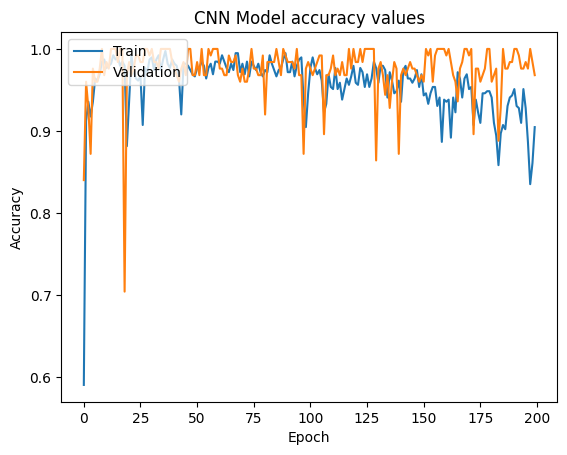

In [ ]:
_# Plot training & validation loss values
plt.plot(model.history.history['binary_accuracy'])
plt.plot(model.history.history['val_binary_accuracy'])
#plt.plot(model.history.history['val_accuracy'])
plt.title('CNN Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

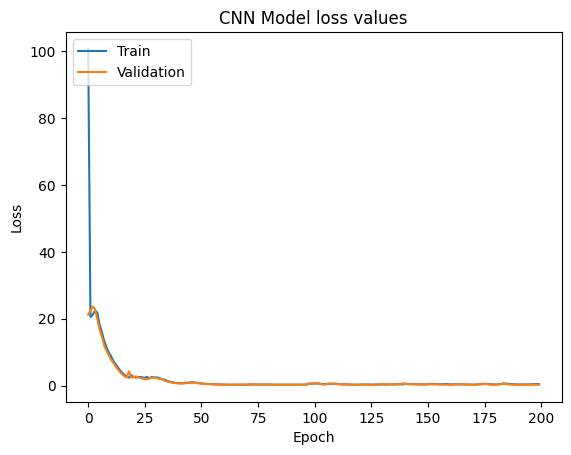

In [ ]:
_# Plot training & validation loss values
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
#plt.plot(model.history['val_loss'])
plt.title('CNN Model loss values')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Confusion Matrix and Classification Report

In [ ]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix , classification_report
import pandas as pd
import seaborn as sns

**Test Model**

In [ ]:
test_path = '/content/drive/MyDrive/test'
data_test = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    labels='inferred',
    label_mode = "int",
    class_names = ['panama', 'healthy'],  # Please ensure these class names match your dataset.
    color_mode= 'rgb',
    batch_size= 32,
    image_size= (224, 224),
    shuffle = False,  # Important: Do not shuffle the test data, to keep predictions and true labels aligned.
)

Found 299 files belonging to 2 classes.


In [ ]:
y_pred_probs = model.predict(data_test)
y_pred = y_pred_probs.flatten()

10/10 [==============================] - 18s 2s/step


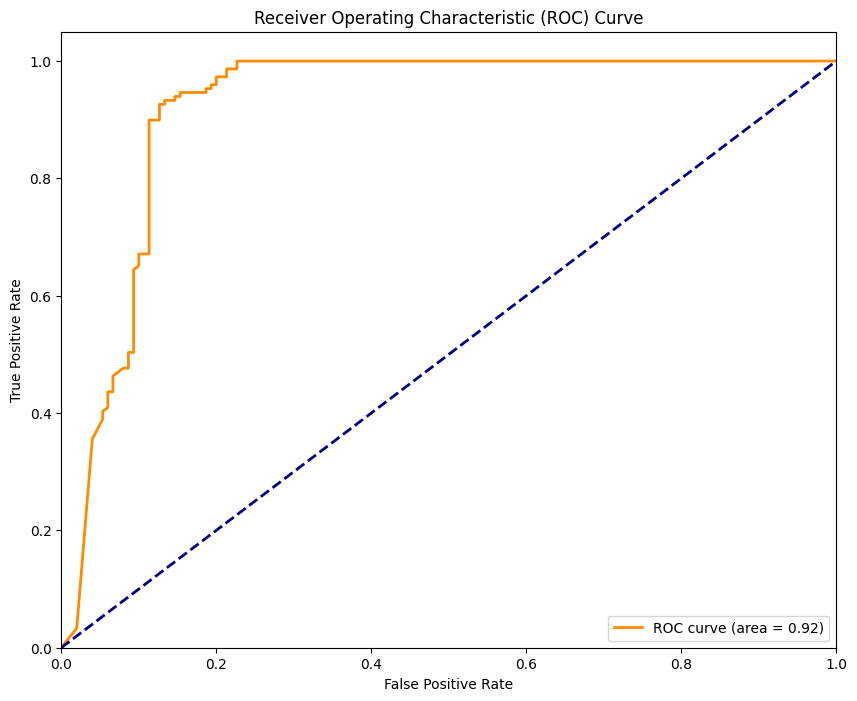

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Fine Tune Model

In [ ]:
_# Plot training & validation loss values
plt.plot(model.history.history['binary_accuracy'])
plt.plot(model.history.history['val_binary_accuracy'])
#plt.plot(model.history.history['binary_val_accuracy'])
plt.title('Fine-Tuning Accuracy Values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [ ]:
_# Plot training & validation loss values
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
#plt.plot(model.history['val_loss'])
plt.title('Fine_Tuning Loss Values')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()